# Implementation and Comparaison of Small VGG11 & GoogleNet:
#### Yassin Bahid

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import time

### Abstract:

After the Success of Alex Krizhevsky at reigniting the field of Deep Learning, multiple Deep Neural Networks architechtures have immerged. While having somewhat different architechtures and philosophies behid them, they all compete in order to achive the best image classification results. Two of the most prominent of such DNN architechtures are the VGG, very deep convolutional networks for Large-Scale Image Recognition, and GoogleNet. We seek to study the efficacy of these two architectures. The two original models are far two computationaly demanding for our system. We shall use the CIFAR10 dataset, consisting of 10 classes and 60000 images distributed evenly.  As such, we will implement a 'smaller' version of these algorithms in order to reduce the training time and to reduce the risks of overfitting the significantly smaller dataset we are using.

### 1 Results:

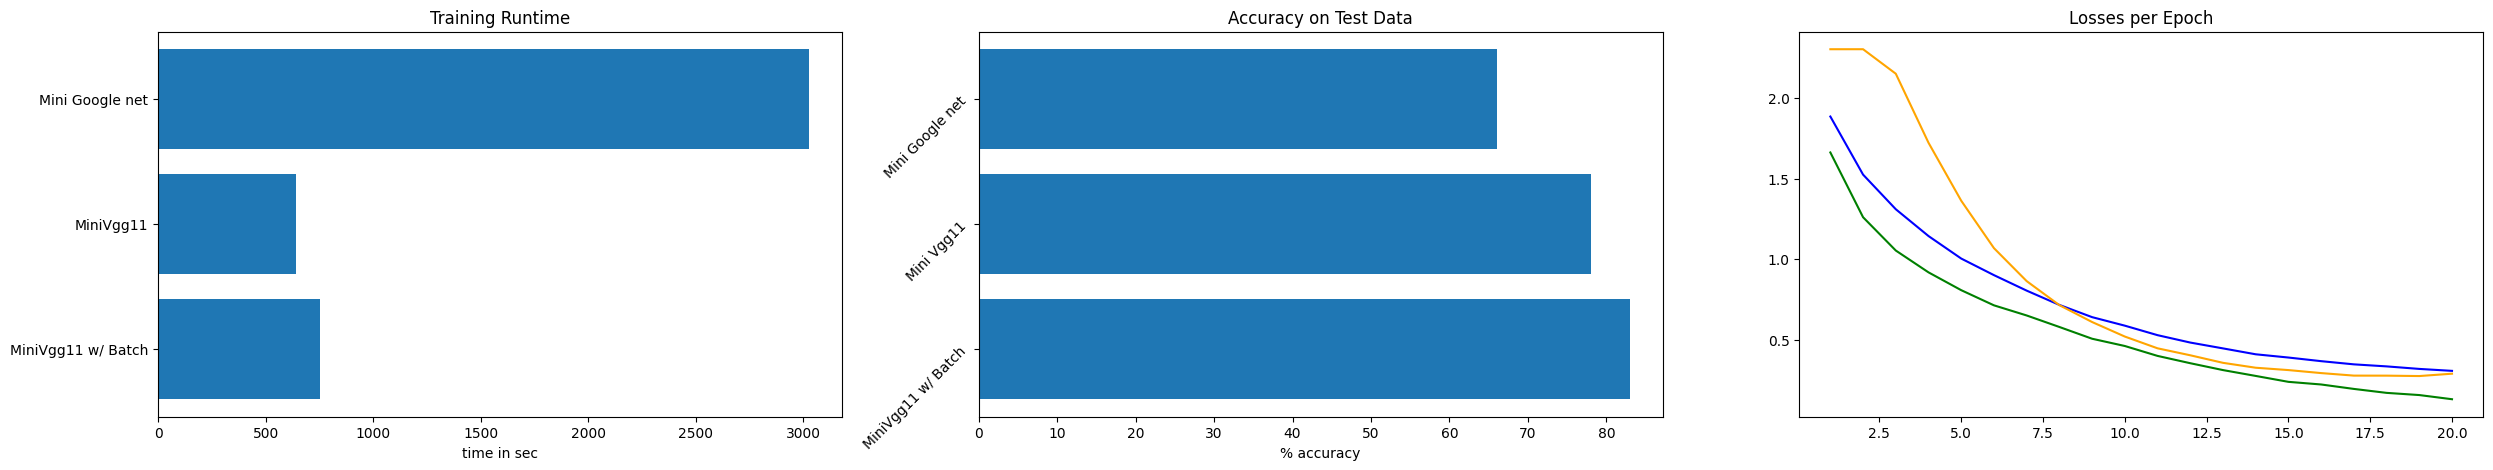

In [62]:

training_times = [train_time_ggnet, minivgg11_train_time, minibtvg11_train_time]
time_labels = ['Mini Google net', 'MiniVgg11', 'MiniVgg11 w/ Batch']
y_pos = np.arange(len(training_times))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,5))

axes[0].barh(y_pos, training_times, align='center')
axes[0].set_yticks(y_pos, labels=time_labels)
axes[0].invert_yaxis()  # labels read top-to-bottom
axes[0].set_xlabel('time in sec')
axes[0].set_title('Training Runtime')


accuracies = [66, 78, 83]
time_labels = ['Mini Google net', 'Mini Vgg11', 'MiniVgg11 w/ Batch']
y_pos = np.arange(len(training_times))



axes[1].barh(y_pos, accuracies, align='center')
axes[1].set_yticks(y_pos, labels=time_labels, rotation = 45)
axes[1].invert_yaxis()  # labels read top-to-bottom
axes[1].set_xlabel('% accuracy')
axes[1].set_title('Accuracy on Test Data')


epochs = [i+1 for i in range(20)] 
axes[2].plot(epochs, np.array(mgg_losses)[:,1], color = 'blue', label = 'Mini GoogleNet' )
axes[2].plot(epochs, np.array(minivgg11_losses)[:,1], color = 'orange', label = 'Mini Vgg11' )
axes[2].plot(epochs, np.array(minibtvg11_losses)[:,1], color = 'green', label = 'Mini Vgg11 w/ BN' )
axes[2].legend
axes[2].set_title('Losses per Epoch')
plt.show()

Google Net  has the largest runtime, which is expected givent the costly arcihtecture.  VGG11 with Batch Nomalization is slightly slower than VGG11. However, it achieves a better accuracy and loss per epoch. There are quite a few improvements one can make to Google Net such as implementing a non Naive version to reduce the runtime. Overall VGG stays a better architechture for the task at hand.

### 2 Theoretical Background:

#### 2.1 Layers:
##### 2.1.1 Convolution Layer: 

In an effort to design different architectures for image recognition, we look at different layer architectures. One such architectures is Convolution. A convolution is filter applied to the image. Different filters can be used to detect different image features such as horizontal or vertical lines, or different shapes that help at classifying the image. Mathematically, a convolution at layer $l$ of size nxn performs the following operation:
$$
y_{ij}^l = \sum_{p=0}^{m-1} \sum_{q=0}^{m-1} w_{pq}y_{(i+p)(j+q)}^{l-1}
$$

A 3x3 convolution would perform the following transformation:
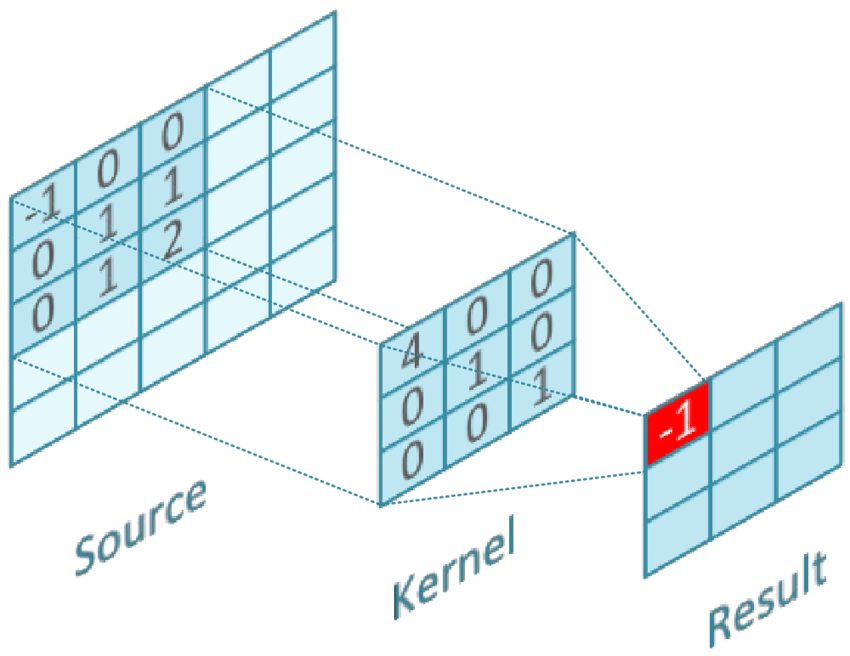
##### 2.1.2 Pooling: 
Pooling is an operation generally performed after  after a convolution layer in order to reduce its translation variance. Max Pooling takes the maximum of neighboring cells, while average pooling takes the average.
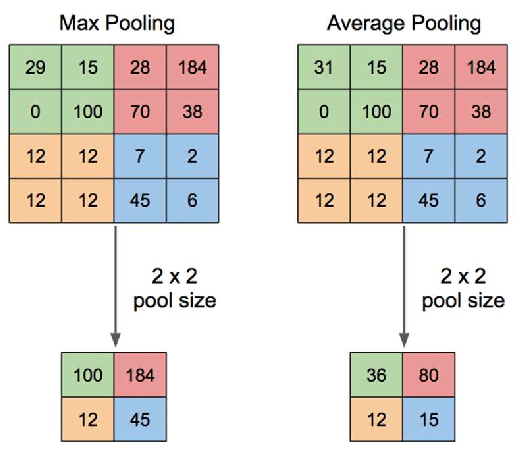
#### 2.2 googlenet:
Now that convolutions are defined, one question that arises is the which nxn convolution is most suitable. Google-net answer this question by using all 3 convolutions: 1x1, 3x3, and 5x5, and concatenating them. The training of the model will do the job of choosing the correct weights assigned to each convolution. As one might think this approach is computationally demanding. We shall implement a small version of this algorithm in section 4.1.


#### 2.3 vgg:
Visual Geometry Group is convolutional Neural Network category that consist of a very deep architecture. Meaning that it is made of a high number of layers: 11, 16, or 19. It starts with Convolutional Layers before transitioning to flat fully connected layers. We choose to test the VGG11 architecture. However, instead of the fully connected layers being 4086x4086 we use smaller values. This architechture is implemented in section 4.2

#### 2.4 Batch Normalization:
One issue one encounters is the irregularity in input data. One can remedy such problem by Normalizing the output after each layer. The mean and standard deviation are calculated from the training data. They are also scaled by two new variables, $\gamma$ and $\beta$, to be optimized during te training that help keep the bias of the output of the previous layer.

$$
BN(\bar{x}) = \gamma \frac{\bar{x} - \mu(\bar{x})}{\sigma (\bar{x})} + \beta
$$
##### 2.4.1 Mini Vgg Batch:

We add the batch norm to our mini VGG architecture after each convolution. We implement this algorithm in section 4.3.

### 3 Data:

We use the CIFAR10 which consist of 10 calsses and 60000 images. This dataset was provided by the university of toronto: https://www.cs.toronto.edu/~kriz/cifar.html.
The classes used are:




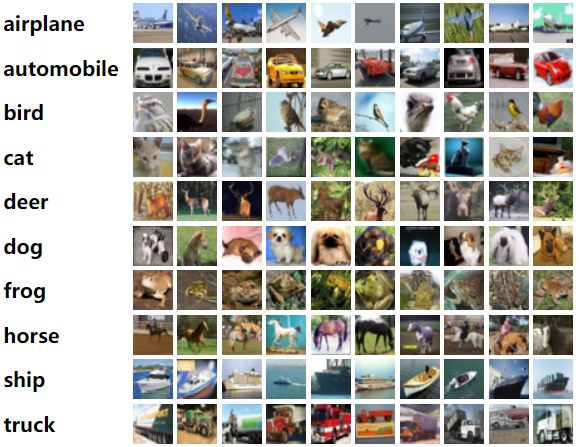


We transform the data into a tensor before nomalizing it.

In [2]:

## Getting Data:

transform = transforms.Compose([transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        transform=transform, download = True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       transform=transform, download = True)

testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### 4 Python Implementation

#### 4.3 Exploring Mini Googlnet Architechture:

In [3]:
class minigooglenet(nn.Module):
    
    def __init__(self, num_classes=10): 
        super(minigooglenet, self).__init__()
        
        #Inception 1:
        self.module11 = nn.Sequential(nn.Conv2d(3, 4, 1),
                                      nn.ReLU()
                                     )
        self.module13 = nn.Sequential(nn.Conv2d(3, 4, 3, padding = 1),
                                      nn.ReLU()
                                     )
        self.module15 = nn.Sequential(nn.Conv2d(3, 4, 5, padding = 2),
                                      nn.ReLU()
                                     )
        
        #Iception 2: (with in features 4+4+4=12 givent the concatenation(see the forward method))
        self.module21 = nn.Sequential(nn.Conv2d(12, 16, 1),
                                      nn.ReLU()
                                     )
        self.module23 = nn.Sequential(nn.Conv2d(12, 16, 3, padding = 1),
                                      nn.ReLU()
                                     )
        self.module25 = nn.Sequential(nn.Conv2d(12, 16, 5, padding = 2),
                                      nn.ReLU()
                                     )
        
        #Inception 3 (with in features 16+16+16=48 givent the concatenation(see the forward method)):
        self.module31 = nn.Sequential(nn.Conv2d(48, 64, 1),
                                      nn.ReLU()
                                     )
        self.module33 = nn.Sequential(nn.Conv2d(48, 64, 3, padding = 1),
                                      nn.ReLU()
                                     )
        self.module35 = nn.Sequential(nn.Conv2d(48, 64, 5, padding = 2),
                                      nn.ReLU()
                                     )
        #Inception 4 (with in features 16+16+16=48 givent the concatenation(see the forward method)):
        self.module41 = nn.Sequential(nn.Conv2d(192, 256, 1),
                                      nn.ReLU()
                                     )
        self.module43 = nn.Sequential(nn.Conv2d(192, 256, 3, padding = 1),
                                      nn.ReLU()
                                     )
        self.module45 = nn.Sequential(nn.Conv2d(192, 256, 5, padding = 2),
                                      nn.ReLU()
                                     )

        
        ##Very dense layers
        self.fc0 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=256*3*32*32, out_features=100),
#             nn.Linear(in_features=64*3*32*32, out_features=100),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(100, 50),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(50, num_classes))
    
    def forward(self, x):
        
        #Inception 1:
        out1 = self.module11(x)
        out2 = self.module13(x)
        out3 = self.module15(x)
        
        out = torch.cat([out1, out2, out3], 1)
        
        #Inception 2:
        out1 = self.module21(out)
        out2 = self.module23(out)
        out3 = self.module25(out)
        
        out = torch.cat([out1, out2, out3], 1)
        
        #Inception 3:
        out1 = self.module31(out)
        out2 = self.module33(out)
        out3 = self.module35(out)
        
        out = torch.cat([out1, out2, out3], 1)
        
        #Inception 4:
        out1 = self.module41(out)
        out2 = self.module43(out)
        out3 = self.module45(out)
        
        out = torch.cat([out1, out2, out3], 1)
        
        
        #Flattening :
        
        out = out.view(out.shape[0], out.shape[1]*out.shape[2]*out.shape[3])
        #Fully connected layer
        out = self.fc0(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
mgglnet = minigooglenet()
mgglnet = mgglnet.to(device)

print(device)

cuda


In [5]:
loss_fct = nn.CrossEntropyLoss()
optimizer = optim.SGD(mgglnet.parameters(), lr=0.003, momentum=0.9)

In [6]:
mgg_losses = [] ##register  epoch & loss
train_time_ggnet = time.time()

for epoch in range(20):  

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
       
        inputs, labels = data  
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = mgglnet(inputs)        

        loss = loss_fct(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
    mgg_losses +=[[epoch+1, running_loss / 6250]] 
    print('epoch : %d , loss = %.3f' % (epoch+1, running_loss / 6250))
    
    if (running_loss / 6250) < 0.05:
        break
train_time_ggnet = time.time() - train_time_ggnet

epoch : 1 , loss = 1.886
epoch : 2 , loss = 1.525
epoch : 3 , loss = 1.310
epoch : 4 , loss = 1.144
epoch : 5 , loss = 1.004
epoch : 6 , loss = 0.901
epoch : 7 , loss = 0.805
epoch : 8 , loss = 0.717
epoch : 9 , loss = 0.641
epoch : 10 , loss = 0.588
epoch : 11 , loss = 0.529
epoch : 12 , loss = 0.483
epoch : 13 , loss = 0.447
epoch : 14 , loss = 0.410
epoch : 15 , loss = 0.390
epoch : 16 , loss = 0.368
epoch : 17 , loss = 0.348
epoch : 18 , loss = 0.335
epoch : 19 , loss = 0.319
epoch : 20 , loss = 0.307


In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

outputs = mgglnet(images)

_, predicted = torch.max(outputs, 1)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = mgglnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy : %d %%' % (
    100 * correct / total))

Accuracy : 66 %


#### 4.2 Exploring Small VGG Architecture:

In [8]:
class MINIVGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(MINIVGG11, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            
            nn.ReLU())
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
           
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            
            nn.ReLU())
        
        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            
            nn.ReLU()#,

        )
        
        ##Very dense layers
        self.fc0 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=512*4*4, out_features=128),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(64, num_classes))
        
    def forward(self, x):

        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        #Flayyening the image for fully dense layers:
        out = out.view(out.size(0), -1)
        out = self.fc0(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [9]:
## Making sure that the network runs on cuda cores
dv = torch.device("cuda" if torch.cuda.is_available() else "cpu")
minivg11 = MINIVGG11().to(dv)
print(dv)

cuda


In [10]:
##Initializing Loss function & optimizer
loss_fct = nn.CrossEntropyLoss()
optimizer = optim.SGD(minivg11.parameters(), lr=0.003, momentum=0.9)

In [11]:
minivgg11_losses = [] ##register  epoch & loss
minivgg11_train_time = time.time()

for epoch in range(20):  

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
       
        inputs, labels = data  
        inputs, labels = inputs.to(dv), labels.to(dv)
        
        optimizer.zero_grad()

        outputs = minivg11(inputs)        

        loss = loss_fct(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
    minivgg11_losses +=[[epoch+1, running_loss / 6250]] 
    print('epoch : %d , loss = %.3f' % (epoch+1, running_loss / 6250))
    
    if (running_loss / 6250) < 0.05:
        break
minivgg11_train_time = time.time() - minivgg11_train_time 

epoch : 1 , loss = 2.304
epoch : 2 , loss = 2.304
epoch : 3 , loss = 2.152
epoch : 4 , loss = 1.723
epoch : 5 , loss = 1.363
epoch : 6 , loss = 1.069
epoch : 7 , loss = 0.864
epoch : 8 , loss = 0.715
epoch : 9 , loss = 0.610
epoch : 10 , loss = 0.520
epoch : 11 , loss = 0.447
epoch : 12 , loss = 0.404
epoch : 13 , loss = 0.357
epoch : 14 , loss = 0.327
epoch : 15 , loss = 0.312
epoch : 16 , loss = 0.294
epoch : 17 , loss = 0.278
epoch : 18 , loss = 0.278
epoch : 19 , loss = 0.275
epoch : 20 , loss = 0.290


In [24]:
##Testing:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = minivg11(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy : %d %%' % (
    100 * correct / total))

Accuracy : 78 %


#### 4.3 Exploring Small VGG with Batch Normalization:

In [18]:
class MINIBATCHVGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(MINIBATCHVGG11, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()#,
            #nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        ##Very dense layers
        self.fc0 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=512*4*4, out_features=128),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(64, num_classes))
        
    def forward(self, x):

        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        #Flayyening the image for fully dense layers:
        out = out.view(out.size(0), -1)
        out = self.fc0(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [19]:
## Making sure that the network runs on cuda cores
dv = torch.device("cuda" if torch.cuda.is_available() else "cpu")
minibtvg11 = MINIBATCHVGG11().to(dv)
print(dv)

cuda


In [20]:
##Initializing Loss function & optimizer
loss_fct = nn.CrossEntropyLoss()
optimizer = optim.SGD(minibtvg11.parameters(), lr=0.003, momentum=0.9)

In [21]:
minibtvg11_losses = [] ##register  epoch & loss
minibtvg11_train_time = time.time()

for epoch in range(20):  

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
       
        inputs, labels = data  
        inputs, labels = inputs.to(dv), labels.to(dv)
        
        optimizer.zero_grad()

        outputs = minibtvg11(inputs)        

        loss = loss_fct(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
    minibtvg11_losses +=[[epoch+1, running_loss / 6250]] 
    print('epoch : %d , loss = %.3f' % (epoch+1, running_loss / 6250))
    
    if (running_loss / 6250) < 0.05:
        break
minibtvg11_train_time = time.time() - minibtvg11_train_time 

epoch : 1 , loss = 1.663
epoch : 2 , loss = 1.261
epoch : 3 , loss = 1.054
epoch : 4 , loss = 0.919
epoch : 5 , loss = 0.808
epoch : 6 , loss = 0.714
epoch : 7 , loss = 0.651
epoch : 8 , loss = 0.580
epoch : 9 , loss = 0.507
epoch : 10 , loss = 0.462
epoch : 11 , loss = 0.400
epoch : 12 , loss = 0.355
epoch : 13 , loss = 0.312
epoch : 14 , loss = 0.276
epoch : 15 , loss = 0.239
epoch : 16 , loss = 0.223
epoch : 17 , loss = 0.195
epoch : 18 , loss = 0.171
epoch : 19 , loss = 0.157
epoch : 20 , loss = 0.131


In [22]:
##Testing:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = minibtvg11(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy : %d %%' % (
    100 * correct / total))

Accuracy : 83 %
